# Pattern prediction for short-term strategies

#### Packages required

In [1]:
import pandas as pd
import numpy as np
import math
import statistics as st
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

### Dataset

#### Dataset consists of the parameters of 3 major stock indices of the country namely NIFTY50, SENSEX and NIFTY Consumption from 01-01-2014 to 31-12-2023

In [2]:
df = pd.read_excel("../datasets/indian_stock_indices/Stock_Indices.xlsx")

In [3]:
df.head()

,Date,SENSEX,NIFTY50,NIFTY_CONSUMPTION
0,2014-01-01,21140.48,6323.80,2590.000000
1,2014-01-02,20888.33,6301.25,2544.649902
2,2014-01-03,20851.33,6194.55,2546.949951
3,2014-01-06,20787.30,6220.85,2544.649902
4,2014-01-07,20693.24,6203.90,2543.399902


In [4]:
total_size = 2469

train_size = 1728 # Training data of 7 years (01-01-2014 to 31-12-2020)
test_size = 741 # Testing data of 3 years (01-01-2021 to 31-12-2023)

### Graph construction

#### Calculating weekly returns and volatilities (over N consecutive days) for SENSEX, NIFTY50 and NIFTY Consumption

In [5]:
N = total_size

sensex_volatilities = []
nifty_volatilities = []
niftyc_volatilities = []

sensex_returns = []
nifty_returns = []
niftyc_returns = []

i = 0
j = 0

while i < N:
    sensex_period_returns = []
    nifty_period_returns = []
    niftyc_period_returns = []
    
    period_size = 1
    
    while ((j + 1) < N) and ((df['Date'][j + 1] - df['Date'][j]) == timedelta(days=1)): # For N-consecutive days
        period_size += 1
#         print(df['SENSEX'][j])

        sensex_ret = math.log(df['SENSEX'][j + 1] / df['SENSEX'][j])
        nifty_ret = math.log(df['NIFTY50'][j + 1] / df['NIFTY50'][j])
        niftyc_ret = math.log(df['NIFTY_CONSUMPTION'][j + 1] / df['NIFTY_CONSUMPTION'][j])
        
        sensex_period_returns.append(sensex_ret)
        nifty_period_returns.append(nifty_ret)
        niftyc_period_returns.append(niftyc_ret)
        
        j += 1
    j += 1
    if len(sensex_period_returns) > 1: # One can use try-catch block here
        sensex_vol = st.stdev(sensex_period_returns) * math.sqrt(period_size)
        nifty_vol = st.stdev(nifty_period_returns) * math.sqrt(period_size)
        niftyc_vol = st.stdev(niftyc_period_returns) * math.sqrt(period_size)
        
    sensex_volatilities.append(sensex_vol)
    nifty_volatilities.append(nifty_vol)
    niftyc_volatilities.append(niftyc_vol)
    
#     print("\n")
    if j < N: # One can use try-catch block here
        sensex_period_return = math.log(df['SENSEX'][j] / df['SENSEX'][j - period_size])
        nifty_period_return = math.log(df['NIFTY50'][j] / df['NIFTY50'][j - period_size])
        niftyc_period_return = math.log(df['NIFTY_CONSUMPTION'][j] / df['NIFTY_CONSUMPTION'][j - period_size])
    sensex_returns.append(sensex_period_return)
    nifty_returns.append(nifty_period_return)
    niftyc_returns.append(nifty_period_return)
    i = j

Testing cell

In [6]:
print(len(sensex_returns))

592


In [7]:
# n = len(sensex_volatilities)
# m = len(sensex_returns)

# for i in range(n):
#     print(sensex_volatilities[i], nifty_volatilities[i], niftyc_volatilities[i])

# print("\n")
# for i in range(m):
#     print(sensex_returns[i], nifty_returns[i], niftyc_returns[i])

In [8]:
# x = np.random.randint(0, 592, 591)

#### Listing the returns and volatilities for the 3 indices

In [9]:
train_percent = 0.75
test_percent = 1 - train_percent

N = len(sensex_returns)

train_sensex_returns = []
train_nifty_returns = []
train_niftyc_returns = []

test_sensex_returns = []
test_nifty_returns = []
test_niftyc_returns = []

train_sensex_volatilities = []
train_nifty_volatilities = []
train_niftyc_volatilities = []

test_sensex_volatilities = []
test_nifty_volatilities = []
test_niftyc_volatilities = []

x = np.random.randint(1, N, N)

for i in range(int(train_percent * N)):
    train_sensex_returns.append(sensex_returns[x[i]])
    train_nifty_returns.append(nifty_returns[x[i]])
    train_niftyc_returns.append(niftyc_returns[x[i]])
    
    train_sensex_volatilities.append(sensex_volatilities[x[i]])
    train_nifty_volatilities.append(nifty_volatilities[x[i]])
    train_niftyc_volatilities.append(niftyc_volatilities[x[i]])
    
for i in range(int(train_percent * N), N, 1):
    test_sensex_returns.append(sensex_returns[x[i]])
    test_nifty_returns.append(nifty_returns[x[i]])
    test_niftyc_returns.append(niftyc_returns[x[i]])
    
    test_sensex_volatilities.append(sensex_volatilities[x[i]])
    test_nifty_volatilities.append(nifty_volatilities[x[i]])
    test_niftyc_volatilities.append(niftyc_volatilities[x[i]])

Testing cell

In [10]:
# print(len(train_sensex_returns))
# print(len(test_sensex_returns))

#### Taking average for comparsion

In [11]:
train_sensex_avg_volatility = np.average(train_sensex_volatilities)
train_nifty_avg_volatility = np.average(train_nifty_volatilities)
train_niftyc_avg_volatility = np.average(train_niftyc_volatilities)

test_sensex_avg_volatility = np.average(test_sensex_volatilities)
test_nifty_avg_volatility = np.average(test_nifty_volatilities)
test_niftyc_avg_volatility = np.average(test_niftyc_volatilities)

Testing cell

In [12]:
# print(train_sensex_avg_volatility)
# print(train_nifty_avg_volatility)
# print(train_niftyc_avg_volatility)
# print('\n')

# print(test_sensex_avg_volatility)
# print(test_nifty_avg_volatility)
# print(test_niftyc_avg_volatility)

#### Creating graph of patterns using base-4 indexing for nodes

In [13]:
window_size = 60 # Window size will determine the size of graphs
train_pattern_graphs = []
train_graph_nodes = []


i = 0
j = window_size

N = len(train_sensex_returns)

while j < N:
    k = i
    
    shape = (64, 64)
    graph = np.zeros(shape)
    nodes = set()
    
    while (k < j):
        
        if train_sensex_returns[k] >= 0 and train_sensex_volatilities[k] >= train_sensex_avg_volatility:
            prev_sensex_index = 0
        if train_sensex_returns[k] >= 0 and train_sensex_volatilities[k] < train_sensex_avg_volatility:
            prev_sensex_index = 1
        if train_sensex_returns[k] < 0 and train_sensex_volatilities[k] >= train_sensex_avg_volatility:
            prev_sensex_index = 2
        if train_sensex_returns[k] < 0 and train_sensex_volatilities[k] < train_sensex_avg_volatility:
            prev_sensex_index = 3
        
        if train_nifty_returns[k] >= 0 and train_nifty_volatilities[k] >= train_nifty_avg_volatility:
            prev_nifty_index = 0
        if train_nifty_returns[k] >= 0 and train_nifty_volatilities[k] < train_nifty_avg_volatility:
            prev_nifty_index = 1
        if train_nifty_returns[k] < 0 and train_nifty_volatilities[k] >= train_nifty_avg_volatility:
            prev_nifty_index = 2
        if train_nifty_returns[k] < 0 and train_nifty_volatilities[k] < train_nifty_avg_volatility:
            prev_nifty_index = 3
        
        if train_niftyc_returns[k] >= 0 and train_niftyc_volatilities[k] >= train_niftyc_avg_volatility:
            prev_niftyc_index = 0
        if train_niftyc_returns[k] >= 0 and train_niftyc_volatilities[k] < train_niftyc_avg_volatility:
            prev_niftyc_index = 1
        if train_niftyc_returns[k] < 0 and train_niftyc_volatilities[k] >= train_niftyc_avg_volatility:
            prev_niftyc_index = 2
        if train_niftyc_returns[k] < 0 and train_niftyc_volatilities[k] < train_niftyc_avg_volatility:
            prev_niftyc_index = 3

        if train_sensex_returns[k + 1] >= 0 and train_sensex_volatilities[k + 1] >= train_sensex_avg_volatility:
            next_sensex_index = 0
        if train_sensex_returns[k + 1] >= 0 and train_sensex_volatilities[k + 1] < train_sensex_avg_volatility:
            next_sensex_index = 1
        if train_sensex_returns[k + 1] < 0 and train_sensex_volatilities[k + 1] >= train_sensex_avg_volatility:
            next_sensex_index = 2
        if train_sensex_returns[k + 1] < 0 and train_sensex_volatilities[k + 1] < train_sensex_avg_volatility:
            next_sensex_index = 3
        
        if train_nifty_returns[k + 1] >= 0 and train_nifty_volatilities[k + 1] >= train_nifty_avg_volatility:
            next_nifty_index = 0
        if train_nifty_returns[k + 1] >= 0 and train_nifty_volatilities[k + 1] < train_nifty_avg_volatility:
            next_nifty_index = 1
        if train_nifty_returns[k + 1] < 0 and train_nifty_volatilities[k + 1] >= train_nifty_avg_volatility:
            next_nifty_index = 2
        if train_nifty_returns[k + 1] < 0 and train_nifty_volatilities[k + 1] < train_nifty_avg_volatility:
            next_nifty_index = 3
        
        if train_niftyc_returns[k + 1] >= 0 and train_niftyc_volatilities[k + 1] >= train_niftyc_avg_volatility:
            next_niftyc_index = 0
        if train_niftyc_returns[k + 1] >= 0 and train_niftyc_volatilities[k + 1] < train_niftyc_avg_volatility:
            next_niftyc_index = 1
        if train_niftyc_returns[k + 1] < 0 and train_niftyc_volatilities[k + 1] >= train_niftyc_avg_volatility:
            next_niftyc_index = 2
        if train_niftyc_returns[k + 1] < 0 and train_niftyc_volatilities[k + 1] < train_niftyc_avg_volatility:
            next_niftyc_index = 3

        
        prev_node = prev_niftyc_index * 4 ** 0 + prev_nifty_index * 4 ** 1 + prev_sensex_index * 4 ** 2
        next_node = next_niftyc_index * 4 ** 0 + next_nifty_index * 4 ** 1 + next_sensex_index * 4 ** 2
        
        graph[prev_node][next_node] += 1
        
        k += 1
        
        nodes.add(prev_node) # Adding nodes in a set for all graphs to keep count
        nodes.add(next_node)
        
    train_graph_nodes.append(nodes)
#     print('\n')
    train_pattern_graphs.append(graph)
    i += 1
    j += 1

In [14]:
window_size = 60 # Window size will determine the size of graphs
test_pattern_graphs = []
test_graph_nodes = []


i = 0
j = window_size

N = len(test_sensex_returns)

while j < N:
    k = i
    
    shape = (64, 64)
    graph = np.zeros(shape)
    nodes = set()
    
    while (k < j):
        
        if test_sensex_returns[k] >= 0 and test_sensex_volatilities[k] >= test_sensex_avg_volatility:
            prev_sensex_index = 0
        if test_sensex_returns[k] >= 0 and test_sensex_volatilities[k] < test_sensex_avg_volatility:
            prev_sensex_index = 1
        if test_sensex_returns[k] < 0 and test_sensex_volatilities[k] >= test_sensex_avg_volatility:
            prev_sensex_index = 2
        if test_sensex_returns[k] < 0 and test_sensex_volatilities[k] < test_sensex_avg_volatility:
            prev_sensex_index = 3
        
        if test_nifty_returns[k] >= 0 and test_nifty_volatilities[k] >= test_nifty_avg_volatility:
            prev_nifty_index = 0
        if test_nifty_returns[k] >= 0 and test_nifty_volatilities[k] < test_nifty_avg_volatility:
            prev_nifty_index = 1
        if test_nifty_returns[k] < 0 and test_nifty_volatilities[k] >= test_nifty_avg_volatility:
            prev_nifty_index = 2
        if test_nifty_returns[k] < 0 and test_nifty_volatilities[k] < test_nifty_avg_volatility:
            prev_nifty_index = 3
        
        if test_niftyc_returns[k] >= 0 and test_niftyc_volatilities[k] >= test_niftyc_avg_volatility:
            prev_niftyc_index = 0
        if test_niftyc_returns[k] >= 0 and test_niftyc_volatilities[k] < test_niftyc_avg_volatility:
            prev_niftyc_index = 1
        if test_niftyc_returns[k] < 0 and test_niftyc_volatilities[k] >= test_niftyc_avg_volatility:
            prev_niftyc_index = 2
        if test_niftyc_returns[k] < 0 and test_niftyc_volatilities[k] < test_niftyc_avg_volatility:
            prev_niftyc_index = 3

        if test_sensex_returns[k + 1] >= 0 and test_sensex_volatilities[k + 1] >= test_sensex_avg_volatility:
            next_sensex_index = 0
        if test_sensex_returns[k + 1] >= 0 and test_sensex_volatilities[k + 1] < test_sensex_avg_volatility:
            next_sensex_index = 1
        if test_sensex_returns[k + 1] < 0 and test_sensex_volatilities[k + 1] >= test_sensex_avg_volatility:
            next_sensex_index = 2
        if test_sensex_returns[k + 1] < 0 and test_sensex_volatilities[k + 1] < test_sensex_avg_volatility:
            next_sensex_index = 3
        
        if test_nifty_returns[k + 1] >= 0 and test_nifty_volatilities[k + 1] >= test_nifty_avg_volatility:
            next_nifty_index = 0
        if test_nifty_returns[k + 1] >= 0 and test_nifty_volatilities[k + 1] < test_nifty_avg_volatility:
            next_nifty_index = 1
        if test_nifty_returns[k + 1] < 0 and test_nifty_volatilities[k + 1] >= test_nifty_avg_volatility:
            next_nifty_index = 2
        if test_nifty_returns[k + 1] < 0 and test_nifty_volatilities[k + 1] < test_nifty_avg_volatility:
            next_nifty_index = 3
        
        if test_niftyc_returns[k + 1] >= 0 and test_niftyc_volatilities[k + 1] >= test_niftyc_avg_volatility:
            next_niftyc_index = 0
        if test_niftyc_returns[k + 1] >= 0 and test_niftyc_volatilities[k + 1] < test_niftyc_avg_volatility:
            next_niftyc_index = 1
        if test_niftyc_returns[k + 1] < 0 and test_niftyc_volatilities[k + 1] >= test_niftyc_avg_volatility:
            next_niftyc_index = 2
        if test_niftyc_returns[k + 1] < 0 and test_niftyc_volatilities[k + 1] < test_niftyc_avg_volatility:
            next_niftyc_index = 3

        
        prev_node = prev_niftyc_index * 4 ** 0 + prev_nifty_index * 4 ** 1 + prev_sensex_index * 4 ** 2
        next_node = next_niftyc_index * 4 ** 0 + next_nifty_index * 4 ** 1 + next_sensex_index * 4 ** 2
        
        graph[prev_node][next_node] += 1
        
        k += 1
        
        nodes.add(prev_node)
        nodes.add(next_node)
        
    test_graph_nodes.append(nodes)
#     print('\n')
    test_pattern_graphs.append(graph)
    i += 1
    j += 1

Testing cell

In [15]:
# for ele in graph_nodes:
#     print(len(ele))

Testing cell

In [16]:
# print(len(train_pattern_graphs))
# print(len(train_graph_nodes))
# print('\n')

# print(len(test_pattern_graphs))
# print(len(test_graph_nodes))

### Centrality Measures as Input variables

#### Finding average degree centrality for training and testing data

In [17]:
train_avg_degree_centralities = []
N = len(train_graph_nodes)

for k in range(N):
    sum = 0
    node = 0
    degree_centrality = 0
    for i in range(64):
        flag = False
        for j in range(64):
            if train_pattern_graphs[k][i][j] > 0:
                sum += 1
                flag = True
        if flag:
            node += 1
    degree_centrality = (1 / node) ** 2 * sum
    train_avg_degree_centralities.append(degree_centrality)

In [18]:
test_avg_degree_centralities = []
N = len(test_graph_nodes)

for k in range(N):
    sum = 0
    node = 0
    degree_centrality = 0
    for i in range(64):
        flag = False
        for j in range(64):
            if test_pattern_graphs[k][i][j] > 0:
                sum += 1
                flag = True
        if flag:
            node += 1
    degree_centrality = (1 / node) ** 2 * sum
    test_avg_degree_centralities.append(degree_centrality)

{'whiskers': [<matplotlib.lines.Line2D at 0x1f1aa951f10>,
 'caps': [<matplotlib.lines.Line2D at 0x1f1aa96c5b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f1aa951c40>],
 'medians': [<matplotlib.lines.Line2D at 0x1f1aa96ca90>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f1aa96cd60>],
 'means': []}

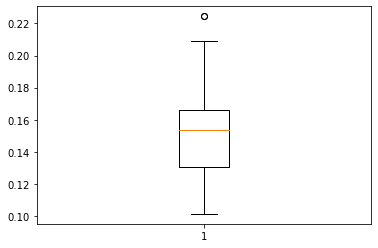

In [19]:
plt.boxplot(train_avg_degree_centralities)

Testing cell

In [20]:
# for ele in avg_degree_centralities:
#     print(ele)

#### Finding average network strength for training and testing data

In [21]:
train_graphs_with_same_strength = defaultdict(list)
test_graphs_with_same_strength = defaultdict(list)

In [22]:
train_avg_network_strengths = []
N = len(train_graph_nodes)


for k in range(N):
    sum = 0
    node = 0
    strength = 0
    for i in range(64):
        flag = False
        for j in range(64):
            if train_pattern_graphs[k][i][j] > 0:
                sum += train_pattern_graphs[k][i][j]
                flag = True
        if flag:
            node += 1
    strength = (1 / len(train_graph_nodes[k])) * sum
#     print("\n")
#     print(type(strength))
    train_avg_network_strengths.append(strength)
    if train_avg_degree_centralities[k] >= 0.12 and train_avg_degree_centralities[k] <= 0.16:
        train_graphs_with_same_strength[strength].append(train_pattern_graphs[k])

Testing cell

In [23]:
# print(graphs_with_same_strength)

In [24]:
test_avg_network_strengths = []
N = len(test_graph_nodes)


for k in range(N):
    sum = 0
    node = 0
    strength = 0
    for i in range(64):
        flag = False
        for j in range(64):
            if test_pattern_graphs[k][i][j] > 0:
                sum += test_pattern_graphs[k][i][j]
                flag = True
        if flag:
            node += 1
    strength = (1 / len(test_graph_nodes[k])) * sum
    test_avg_network_strengths.append(strength)
    if test_avg_degree_centralities[k] >= 0.12 and test_avg_degree_centralities[k] <= 0.16:
        test_graphs_with_same_strength[strength].append(test_pattern_graphs[k])

Testing cell

In [25]:
# for ele in avg_network_strengths:
#     print(ele)

#### Finding average closeness centrality for training and testing data

In [26]:
def floyd_warshall(graph):
    V = 64
    shape = (64, 64)
    shortest_graph = np.zeros(shape)
    for k in range(0, V):
        for i in range(0, V):
            for j in range(0, V):
                if graph[i][j] > graph[i][k] + graph[k][j] and graph[k][j] != 0 and graph[i][k] != 0:
                    shortest_graph[i][j] = shortest_graph[i][k] + shortest_graph[k][j]
    return shortest_graph    

In [27]:
train_avg_closeness_centrality = []
N = len(train_graph_nodes)

for k in range(N):
    shortest_graph = floyd_warshall(train_pattern_graphs[k])
    node = 0
    closeness_sum = 0
    avg_closeness = 0
    sum = 0
    for i in range(64):
        for j in range(64):
                sum += train_pattern_graphs[k][i][j]
        if sum > 0:
            closeness_sum += (len(train_graph_nodes[k]) - 1) / sum
    avg_closeness = (1 / len(train_graph_nodes[k])) * closeness_sum
    train_avg_closeness_centrality.append(avg_closeness)   

In [28]:
test_avg_closeness_centrality = []
N = len(test_graph_nodes)

for k in range(N):
    shortest_graph = floyd_warshall(test_pattern_graphs[k])
    node = 0
    closeness_sum = 0
    avg_closeness = 0
    sum = 0
    for i in range(64):
        for j in range(64):
            if test_pattern_graphs[k][i][j] > 0:
                sum += test_pattern_graphs[k][i][j]
        closeness_sum += (len(test_graph_nodes[k]) - 1) / sum
    avg_closeness = (1 / len(test_graph_nodes[k])) * closeness_sum
    test_avg_closeness_centrality.append(avg_closeness) 

#### Elbow method to determine the optimal value of K for K-means algorithm

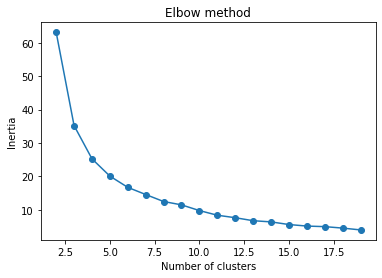

In [29]:
data = list(zip(train_avg_degree_centralities, train_avg_network_strengths, train_avg_closeness_centrality))
inertias = []
# scores = []

for i in range(2,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
#     ss = silhouette_score(data, kmeans.fit_predict(data))
#     scores.append(ss)
#     print(silhouette_score(data, kmeans.fit_predict(data)))
    inertias.append(kmeans.inertia_)

plt.plot(range(2,20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [30]:
# data = list(zip(test_avg_degree_centralities, test_avg_network_strengths))
# inertias = []

# for i in range(1,10):
#     kmeans = KMeans(n_clusters=i)
#     kmeans.fit(data)
#     inertias.append(kmeans.inertia_)

# plt.plot(range(1,10), inertias, marker='o')
# plt.title('Elbow method')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')
# plt.show()

Testing cell

In [31]:
# for ele in inertias:
#     print(ele)

Text(0, 0.5, 'Network strengths')

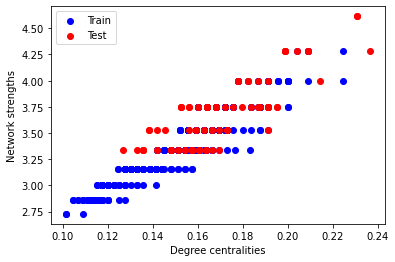

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(train_avg_degree_centralities, train_avg_network_strengths, color='blue')
ax.scatter(test_avg_degree_centralities, test_avg_network_strengths, color='red')
ax.legend(['Train', 'Test'])
ax.set_xlabel('Degree centralities')
ax.set_ylabel('Network strengths')

Text(0, 0.5, 'Network strengths')

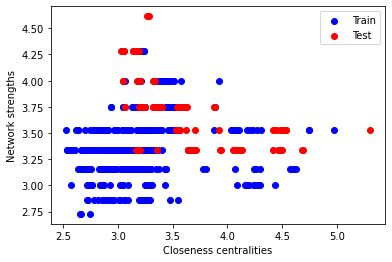

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(train_avg_closeness_centrality, train_avg_network_strengths, color='blue')
ax.scatter(test_avg_closeness_centrality, test_avg_network_strengths, color='red')
ax.legend(['Train', 'Test'])
ax.set_xlabel('Closeness centralities')
ax.set_ylabel('Network strengths')

Text(0, 0.5, 'Degree centralities')

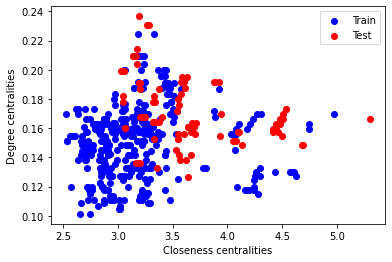

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(train_avg_closeness_centrality, train_avg_degree_centralities, color='blue')
ax.scatter(test_avg_closeness_centrality, test_avg_degree_centralities, color='red')
ax.legend(['Train', 'Test'])
ax.set_xlabel('Closeness centralities')
ax.set_ylabel('Degree centralities')

Text(0.5, 0, 'Closeness centralities')

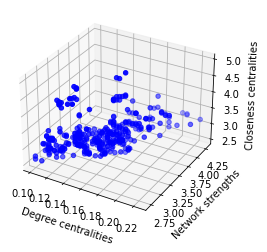

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(train_avg_degree_centralities, train_avg_network_strengths, train_avg_closeness_centrality, color='blue')
ax.set_xlabel('Degree centralities')
ax.set_ylabel('Network strengths')
ax.set_zlabel('Closeness centralities')

### Elbow method to find out the optimal value of K for K-Means

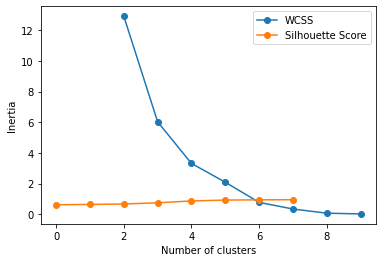

In [36]:
data = list(zip(train_avg_degree_centralities, train_avg_network_strengths))
inertias = []
silhouettes = []

for i in range(2,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    ss = silhouette_score(data, kmeans.fit_predict(data))
    silhouettes.append(ss)
#     print(ss)
    inertias.append(kmeans.inertia_)

plt.plot(range(2,10), inertias, silhouettes, marker='o')
plt.legend(['WCSS', 'Silhouette Score'])
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

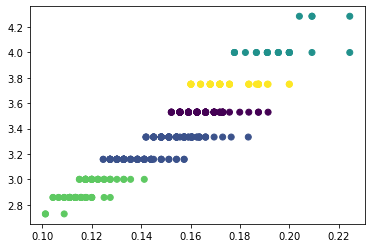

In [37]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(data)

plt.scatter(train_avg_degree_centralities, train_avg_network_strengths, c=kmeans.labels_)
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x1f1acc765e0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f1acc76b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f1acc76310>],
 'medians': [<matplotlib.lines.Line2D at 0x1f1acc71160>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f1acc71430>],
 'means': []}

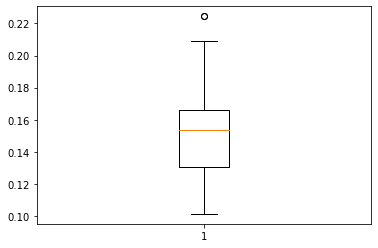

In [38]:
plt.boxplot(train_avg_degree_centralities)

{'whiskers': [<matplotlib.lines.Line2D at 0x1f1adf81dc0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f1adf943a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f1adf81af0>],
 'medians': [<matplotlib.lines.Line2D at 0x1f1adf94940>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f1adf94c10>],
 'means': []}

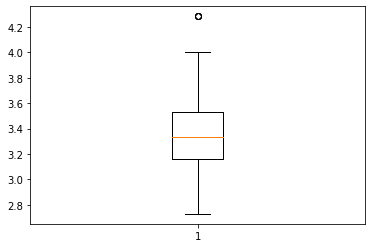

In [39]:
plt.boxplot(train_avg_network_strengths)

In [40]:
# for key1, value1 in test_graphs_with_same_strength.items():
#     for key2, value2 in train_graphs_with_same_strength.items():
# #         print(type(key1))
#         if key1 == key2:
#             test_graphs = []
#             train_graphs = []
            
#             test_graphs = value1
#             train_graphs = value2
            
#             for test_graph in test_graphs:
#                 for train_graph in train_graphs:
#                     train_nodes = 0
#                     test_nodes = 0
#                     equals = 0
#                     both_pos = 0
                    
                    
#                     for i in range(64):
#                         for j in range(64):
#                             if train_graph[i][j] > 0:
#                                 train_nodes += 1
#                             if test_graph[i][j] > 0:
#                                 test_nodes += 1
#                             if train_graph[i][j] > 0 and test_graph[i][j] > 0:
#                                 both_pos += 1
#                                 print(train_graph[i][j], test_graph[i][j])
#                     min_nodes = min (train_nodes, test_nodes)
#                     print('\n')
# #                     print(equals, min_nodes, both_pos)

In [41]:
hybrid_graphs = {}

for key, value in train_graphs_with_same_strength.items():
    graphs = []
    graphs = value
    
    shape = (64, 64)
    hybrid_graph = np.zeros(shape)
    
    for i in range(64):
        for j in range(64):
            xor = 0
            for k in range(len(graphs)):
                xor = xor ^ int(graph[i][j])
            hybrid_graph[i][j] = xor
    hybrid_graphs[key] = hybrid_graph      

In [42]:
accuracy = 0.0

correct = 0
final_total = 0
for key1, value1 in hybrid_graphs.items():
    for key2, value2 in test_graphs_with_same_strength.items():
        if key1 == key2:
            test_graphs = []
            test_graphs = value2
            hybrid_graph = value1
            
            for test_graph in test_graphs:
                equals = 0
                total = 0
                for i in range(64):
                    for j in range(64):
                        if test_graph[i][j] > 0 and hybrid_graph[i][j] > 0:
                            total += 1
                        if test_graph[i][j] > 0 and hybrid_graph[i][j] > 0 and test_graph[i][j] == hybrid_graph[i][j]:
                            equals += 1
#                             print(test_graph[i][j], hybrid_graph[i][j])
#                 print(equals, total)
                correct += equals
                final_total += total
#             print('\n')
print(correct)
print(final_total)

504
573


In [43]:
relevant = 0
for ele in train_avg_degree_centralities:
    if ele >= 0.13 and ele <= 0.17:
        relevant += 1
print(relevant)
print(len(train_avg_degree_centralities))

233
384
